In [2]:
# External Libraries
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# -----------------------------
# Motion Model calibration constants (from your notebooks)
# -----------------------------

# Section 4: Distance mapping s = K_SE * e_fwd, where e_fwd = -(delta encoder counts)
K_SE = 2.882760254750430982e-04  # meters per count

# Section 4: Distance variance sigma_s^2 = K_SS * e_fwd (through origin)
K_SS = 6.338605358524558586e-08  # (m^2) per count

# Phase 3: speed command -> encoder rate r(v) (counts/sec), through origin polynomial
# Replace these with your final coefficients:
A1 = -2.389748299319578351e+01
A2 = 8.136904761904759642e-01
A3 = -4.658503401360606679e-03


# Section 5: yaw-rate coupling using encoder rate:
# w = (C_R * r(v)) * alpha_cmd
# Replace C_R with your fitted value from yawrate notebook:
C_R = 3.526364371043103914e-05 # (rad/s) per (count/s)

# Section 5: yaw-rate variance (constant)
SIGMA_W2_CONST = 1.601538811297278713e-03  # (rad/s)^2

# Fancy model hyperparameters (tunable)
SIGMA_BETA = math.radians(1.0)   # slip angle std (rad), small
SIGMA_BIAS = math.radians(0.5)   # yaw-bias random walk std per sqrt(sec) (rad/sqrt(s))

# Numerics
DTH_EPS = 1e-8


In [4]:
def wrap_to_pi(angle_rad: float) -> float:
    return (angle_rad + math.pi) % (2.0 * math.pi) - math.pi

def through_origin_slope(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    denom = float(x @ x)
    return float((x @ y) / denom) if denom > 1e-12 else 0.0

In [5]:
def distance_travelled_s(delta_encoder_counts: float) -> float:
    """
    s = K_SE * e_fwd, where e_fwd = -delta_e.
    Raw encoder delta is negative for forward motion.
    """
    delta_e = float(delta_encoder_counts)
    e_fwd = -delta_e
    return K_SE * e_fwd

def variance_distance_travelled_s(e_fwd_counts: float) -> float:
    """
    sigma_s^2 = K_SS * e_fwd (through origin), clipped to nonnegative.
    """
    e = float(e_fwd_counts)
    if e < 0.0:
        e = abs(e)
    return max(0.0, K_SS * e)

In [11]:
def counts_per_sec_from_speed(v_cmd, v_min=40.0, v_max=100.0):
    v = float(np.clip(v_cmd, v_min, v_max))
    r = A1*v + A2*(v**2) + A3*(v**3)
    return max(0.0, r)

def variance_counts_rate(v_cmd: float) -> float:
    """
    Optional: encoder-rate variance model vs speed.
    If you fitted sigma_r^2 = k_r * v (through origin), put it here.
    For now we keep it 0 (deterministic rate) to avoid double-noising.
    """
    return 0.0

In [12]:
def rotational_velocity_w(v_cmd: float, steering_cmd: float) -> float:
    """
    Linear yaw model consistent with our motion model assumptions:
      w = (C_R * r(v)) * alpha_cmd
    steering_cmd is servo units in [-20,20], NOT radians.
    Returns w in rad/s.
    """
    r = counts_per_sec_from_speed(v_cmd)  # counts/s
    return (C_R * r) * float(steering_cmd)

def variance_rotational_velocity_w(v_cmd: float, steering_cmd: float) -> float:
    """
    Constant yaw-rate variance.
    """
    return SIGMA_W2_CONST


In [13]:
class UnicycleModel:
    """
    State x = [x_G, y_G, theta_G].
    Uses:
      Δs from encoder deltas
      w from (v_cmd, alpha_cmd)
    """
    def __init__(self, initial_state=(0.0, 0.0, 0.0), last_encoder_count=0.0, add_noise=True):
        self.state = [float(initial_state[0]), float(initial_state[1]), float(initial_state[2])]
        self.last_encoder_count = float(last_encoder_count)
        self.add_noise = bool(add_noise)

    def step_update(self, encoder_counts, v_cmd, steering_cmd, dt):
        enc = float(encoder_counts)
        dt = float(dt)

        # encoder delta
        delta_e = enc - self.last_encoder_count
        self.last_encoder_count = enc

        # mean controls
        s = distance_travelled_s(delta_e)
        w = rotational_velocity_w(v_cmd, steering_cmd)

        # sample noise
        if self.add_noise:
            e_fwd = -delta_e
            var_s = variance_distance_travelled_s(e_fwd)
            s = s + random.gauss(0.0, math.sqrt(var_s)) if var_s > 0 else s

            var_w = variance_rotational_velocity_w(v_cmd, steering_cmd)
            w = w + random.gauss(0.0, math.sqrt(var_w)) if var_w > 0 else w

        # exact constant-curvature update
        x, y, th = self.state
        dth = w * dt

        if abs(dth) < DTH_EPS:
            x_new = x + s * math.cos(th)
            y_new = y + s * math.sin(th)
            th_new = th + dth
        else:
            R = s / dth
            th2 = th + dth
            x_new = x + R * (math.sin(th2) - math.sin(th))
            y_new = y - R * (math.cos(th2) - math.cos(th))
            th_new = th2

        self.state = [x_new, y_new, wrap_to_pi(th_new)]
        return self.state


In [14]:
class AckermannBicycleModel:
    """
    Ackermann/bicycle-style kinematic update using sampled (s, w).
    This model keeps the same calibrated inputs but uses a mid-heading update:
      x += s cos(theta + 0.5*dtheta)
      y += s sin(theta + 0.5*dtheta)
      theta += dtheta
    """
    def __init__(self, initial_state=(0.0, 0.0, 0.0), last_encoder_count=0.0, add_noise=True):
        self.state = [float(initial_state[0]), float(initial_state[1]), float(initial_state[2])]
        self.last_encoder_count = float(last_encoder_count)
        self.add_noise = bool(add_noise)

    def step_update(self, encoder_counts, v_cmd, steering_cmd, dt):
        enc = float(encoder_counts)
        dt = float(dt)

        delta_e = enc - self.last_encoder_count
        self.last_encoder_count = enc

        s = distance_travelled_s(delta_e)
        w = rotational_velocity_w(v_cmd, steering_cmd)

        if self.add_noise:
            e_fwd = -delta_e
            var_s = variance_distance_travelled_s(e_fwd)
            s = s + random.gauss(0.0, math.sqrt(var_s)) if var_s > 0 else s

            var_w = variance_rotational_velocity_w(v_cmd, steering_cmd)
            w = w + random.gauss(0.0, math.sqrt(var_w)) if var_w > 0 else w

        x, y, th = self.state
        dth = w * dt

        th_mid = th + 0.5 * dth
        x_new = x + s * math.cos(th_mid)
        y_new = y + s * math.sin(th_mid)
        th_new = th + dth

        self.state = [x_new, y_new, wrap_to_pi(th_new)]
        return self.state


In [15]:
class FancySlipBiasModel:
    """
    Adds:
      - slip angle beta ~ N(0, SIGMA_BETA^2) per step
      - yaw-rate bias b_t random-walk (bias in rad/s)
    """
    def __init__(self, initial_state=(0.0, 0.0, 0.0), last_encoder_count=0.0, add_noise=True):
        self.state = [float(initial_state[0]), float(initial_state[1]), float(initial_state[2])]
        self.last_encoder_count = float(last_encoder_count)
        self.add_noise = bool(add_noise)
        self.bias_w = 0.0  # rad/s

    def step_update(self, encoder_counts, v_cmd, steering_cmd, dt):
        enc = float(encoder_counts)
        dt = float(dt)

        delta_e = enc - self.last_encoder_count
        self.last_encoder_count = enc

        s = distance_travelled_s(delta_e)
        w = rotational_velocity_w(v_cmd, steering_cmd)

        # sample noise (distance and yaw)
        if self.add_noise:
            e_fwd = -delta_e
            var_s = variance_distance_travelled_s(e_fwd)
            s = s + random.gauss(0.0, math.sqrt(var_s)) if var_s > 0 else s

            var_w = variance_rotational_velocity_w(v_cmd, steering_cmd)
            w = w + random.gauss(0.0, math.sqrt(var_w)) if var_w > 0 else w

            # slip angle (rad)
            beta = random.gauss(0.0, SIGMA_BETA)

            # yaw bias random walk: std scales with sqrt(dt)
            self.bias_w = self.bias_w + random.gauss(0.0, SIGMA_BIAS * math.sqrt(max(dt, 1e-9)))
        else:
            beta = 0.0

        x, y, th = self.state
        dth = (w + self.bias_w) * dt

        # slip affects translational direction
        x_new = x + s * math.cos(th + beta)
        y_new = y + s * math.sin(th + beta)
        th_new = th + dth

        self.state = [x_new, y_new, wrap_to_pi(th_new)]
        return self.state


In [30]:
# Trajectory sequence: (speed_cmd, steering_angle, duration_sec)
# steering_angle: positive LEFT, negative RIGHT (servo setpoint units or "degrees-like" units)
#TRAJ. 1: Simple square
TRAJECTORY_SEQUENCE = [
    (100, 0, 1.0),   # Straight for 2s
    (100, 10, 2.0),  # Left turn for 2s
    (80, -10, 2.0),  # Right turn for 2s
    (100, 0, 1.0)    # Straight for 2s
]

#TRAJ. 2: S-shape
# TRAJECTORY_SEQUENCE = [
#     (70, 0, 1.0),   # Straight for 2s
#     (60, 10, 2.0),  # Left turn for 2s
#     (80, 10, 2.0),  # Right turn for 2s
#     (100, 0, 1.0)    # Straight for 2s
# ]

# #TRAJ. 3: Simple stop-start with turn
# TRAJECTORY_SEQUENCE = [
#     (0, 0, 1.0),      # Full stop
#     (60, 0, 1.5),     # Slow straight
#     (60, 12, 1.5),    # Turn while moving slowly
#     (0, 0, 1.0),      # Stop again
#     (100, 0, 1.5)    # Fast straight
# ]

# TRAJ. 4: Zig-zag
# TRAJECTORY_SEQUENCE = [
#     (80, 15, 1.0),    # Hard left
#     (80, -15, 1.0),   # Hard right
#     (80, 15, 1.0),
#     (80, -15, 1.0),
#     (100, 0, 1.0)     # Straight exit
# ]


In [17]:
def simulate_one_run_from_sequence(model_cls, trajectory_sequence, dt=0.05, add_noise=True, seed=None):
    """
    Simulate one run given a model class and TRAJECTORY_SEQUENCE formatted as:
      [(speed_cmd, steering_angle, duration_sec), ...]
    Returns final (x, y, theta).
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    model = model_cls(initial_state=(0.0, 0.0, 0.0), last_encoder_count=0.0, add_noise=add_noise)

    encoder_counts = 0.0  # cumulative raw counts (forward -> more negative)

    for (v_cmd, steering_angle, duration) in trajectory_sequence:
        steps = int(math.ceil(duration / dt))
        for _ in range(steps):
            # encoder rate (counts/sec) from speed command
            r = counts_per_sec_from_speed(v_cmd)

            # optional: rate noise (usually 0 to avoid double-noising)
            var_r = variance_counts_rate(v_cmd)
            if var_r > 0.0:
                r = max(0.0, r + random.gauss(0.0, math.sqrt(var_r)))

            # accumulate encoder counts (forward is negative)
            encoder_counts -= r * dt

            # IMPORTANT: steering_angle is positive LEFT, negative RIGHT
            model.step_update(encoder_counts, v_cmd, steering_angle, dt)

    return tuple(model.state)


In [35]:
# def monte_carlo_endpoints_from_sequence(model_cls, trajectory_sequence, n_runs=300, dt=0.05, seed=0):
#     xs, ys, ths = [], [], []

#     for i in range(n_runs):
#         x, y, th = simulate_one_run_from_sequence(
#             model_cls=model_cls,
#             trajectory_sequence=trajectory_sequence,
#             dt=dt,
#             add_noise=True,
#             seed=seed + i
#         )
#         xs.append(x); ys.append(y); ths.append(th)

#     xs = np.array(xs); ys = np.array(ys); ths = np.array(ths)
#     mean = np.array([xs.mean(), ys.mean()])
#     cov = np.cov(xs, ys)
#     return xs, ys, ths, mean, cov
def monte_carlo_endpoints_from_sequence(model_cls, trajectory_sequence, n_runs=300, dt=0.05, seed=0, verbose=True):
    xs, ys, ths = [], [], []

    for i in range(n_runs):
        x, y, th = simulate_one_run_from_sequence(
            model_cls=model_cls,
            trajectory_sequence=trajectory_sequence,
            dt=dt,
            add_noise=True,
            seed=seed + i
        )
        xs.append(x); ys.append(y); ths.append(th)

    xs = np.array(xs); ys = np.array(ys); ths = np.array(ths)

    mean_xy = np.array([xs.mean(), ys.mean()])
    cov_xy = np.cov(xs, ys)

    # yaw stats (wrap-safe mean)
    mean_sin = np.mean(np.sin(ths))
    mean_cos = np.mean(np.cos(ths))
    mean_yaw = math.atan2(mean_sin, mean_cos)
    # "circular" std (approx): use resultant length R
    R = math.sqrt(mean_sin**2 + mean_cos**2)
    yaw_std = math.sqrt(max(0.0, -2.0 * math.log(max(R, 1e-12))))

    if verbose:
        print(f"[{model_cls.__name__}] mean end (x,y)=({mean_xy[0]:.4f},{mean_xy[1]:.4f})")
        print(f"[{model_cls.__name__}] mean yaw (rad)={mean_yaw:.4f}, yaw std (rad)≈{yaw_std:.4f}")
        print(f"[{model_cls.__name__}] mean yaw (deg)={math.degrees(mean_yaw):.2f}, yaw std (deg)≈{math.degrees(yaw_std):.2f}")
        print(f"[{model_cls.__name__}] cov(x,y)=\n{cov_xy}\n")

    return xs, ys, ths, mean_xy, cov_xy, mean_yaw, yaw_std


In [32]:
ACTUAL_CENTER = (1.7, 0.45)  # meters
ACTUAL_N = 5
ACTUAL_JITTER = 0.015  # meters

# If you have real measured points, paste them like:
# ACTUAL_POINTS = np.array([[1.692,0.458],[1.708,0.444],...])

rng = np.random.default_rng(123)
ACTUAL_POINTS = np.column_stack([
    ACTUAL_CENTER[0] + rng.uniform(-ACTUAL_JITTER, ACTUAL_JITTER, size=ACTUAL_N),
    ACTUAL_CENTER[1] + rng.uniform(-ACTUAL_JITTER, ACTUAL_JITTER, size=ACTUAL_N),
])

ACTUAL_POINTS


array([[1.70547056, 0.45936284],
       [1.68661463, 0.46270035],
       [1.6916108 , 0.44329723],
       [1.69053115, 0.45959264],
       [1.69027718, 0.46169678]])

In [19]:
def plot_endpoints(xs, ys, mean, title):
    plt.figure(figsize=(6,6))
    plt.scatter(xs, ys, s=12, alpha=0.6)
    plt.scatter([mean[0]], [mean[1]], s=80, marker="x")
    plt.xlabel("x_G (m) forward")
    plt.ylabel("y_G (m) right")
    plt.title(title)
    plt.grid(True)
    plt.axis("equal")
    plt.show()

In [33]:
def plot_endpoints_with_actual(xs, ys, mean_xy, actual_points, title):
    plt.figure(figsize=(6,6))

    # simulated endpoints
    plt.scatter(xs, ys, s=12, alpha=0.55, label="Simulated endpoints")

    # simulated mean
    plt.scatter([mean_xy[0]], [mean_xy[1]], s=90, marker="x", label="Sim mean")

    # actual readings (5 points)
    if actual_points is not None:
        ap = np.asarray(actual_points, dtype=float)
        plt.scatter(ap[:,0], ap[:,1], s=70, marker="*", label="Actual (5 readings)")
        plt.scatter([ap[:,0].mean()], [ap[:,1].mean()], s=90, marker="o", label="Actual mean")

    plt.xlabel("x_G (m) forward")
    plt.ylabel("y_G (m) right")
    plt.title(title)
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
    plt.show()


Unicycle mean: [1.65778616 0.49194015] 
Unicycle cov:
 [[ 3.71257636e-04 -4.96018343e-05]
 [-4.96018343e-05  4.56603461e-04]]


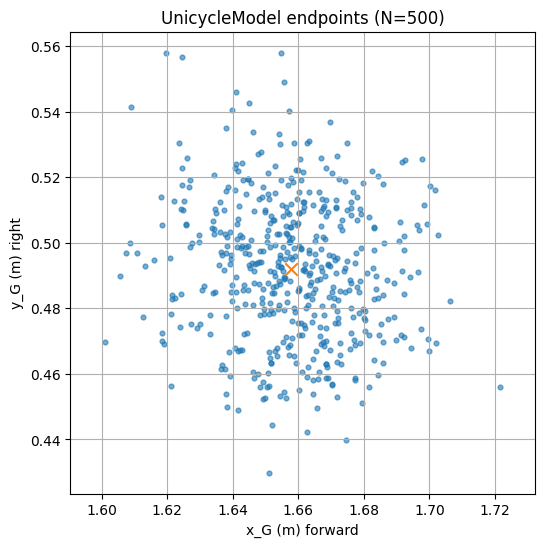

Ackermann mean: [1.65780015 0.49194616] 
Ackermann cov:
 [[ 3.71261646e-04 -4.96005719e-05]
 [-4.96005719e-05  4.56612875e-04]]


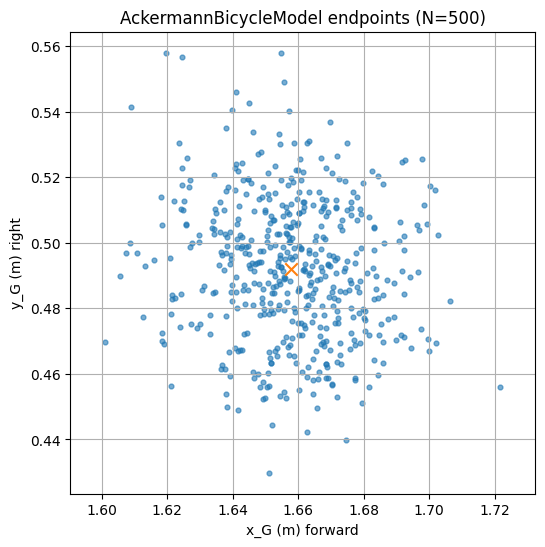

Fancy mean: [1.65717721 0.490863  ] 
Fancy cov:
 [[ 0.00067089 -0.00076757]
 [-0.00076757  0.00256025]]


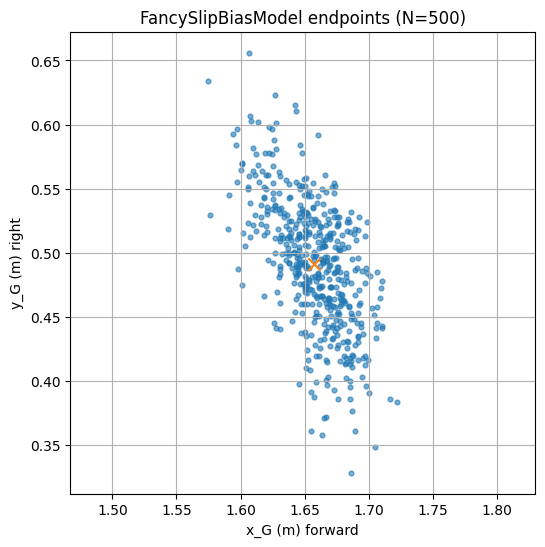

In [31]:
N_RUNS = 500
DT = 0.05

# Unicycle
xs, ys, ths, mean, cov = monte_carlo_endpoints_from_sequence(UnicycleModel, TRAJECTORY_SEQUENCE, n_runs=N_RUNS, dt=DT, seed=10)
print("Unicycle mean:", mean, "\nUnicycle cov:\n", cov)
plot_endpoints(xs, ys, mean, f"UnicycleModel endpoints (N={N_RUNS})")

# Ackermann-like
xs, ys, ths, mean, cov = monte_carlo_endpoints_from_sequence(AckermannBicycleModel, TRAJECTORY_SEQUENCE, n_runs=N_RUNS, dt=DT, seed=10)
print("Ackermann mean:", mean, "\nAckermann cov:\n", cov)
plot_endpoints(xs, ys, mean, f"AckermannBicycleModel endpoints (N={N_RUNS})")

# Fancy slip+bias
xs, ys, ths, mean, cov = monte_carlo_endpoints_from_sequence(FancySlipBiasModel, TRAJECTORY_SEQUENCE, n_runs=N_RUNS, dt=DT, seed=10)
print("Fancy mean:", mean, "\nFancy cov:\n", cov)
plot_endpoints(xs, ys, mean, f"FancySlipBiasModel endpoints (N={N_RUNS})")


[UnicycleModel] mean end (x,y)=(1.6578,0.4919)
[UnicycleModel] mean yaw (rad)=0.1260, yaw std (rad)≈0.0213
[UnicycleModel] mean yaw (deg)=7.22, yaw std (deg)≈1.22
[UnicycleModel] cov(x,y)=
[[ 3.71257636e-04 -4.96018343e-05]
 [-4.96018343e-05  4.56603461e-04]]



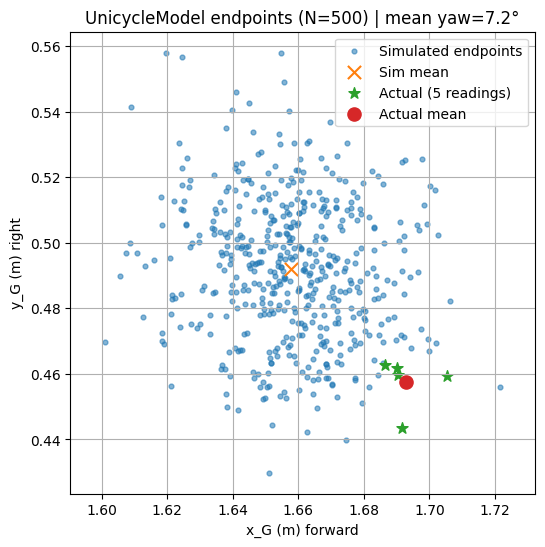

[AckermannBicycleModel] mean end (x,y)=(1.6578,0.4919)
[AckermannBicycleModel] mean yaw (rad)=0.1260, yaw std (rad)≈0.0213
[AckermannBicycleModel] mean yaw (deg)=7.22, yaw std (deg)≈1.22
[AckermannBicycleModel] cov(x,y)=
[[ 3.71261646e-04 -4.96005719e-05]
 [-4.96005719e-05  4.56612875e-04]]



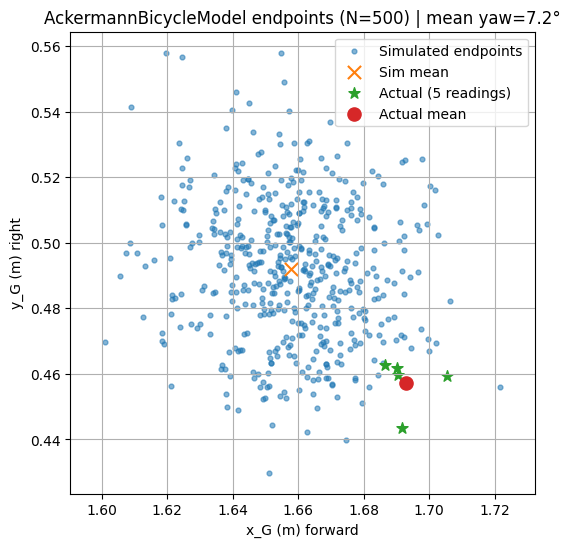

[FancySlipBiasModel] mean end (x,y)=(1.6572,0.4909)
[FancySlipBiasModel] mean yaw (rad)=0.1276, yaw std (rad)≈0.0788
[FancySlipBiasModel] mean yaw (deg)=7.31, yaw std (deg)≈4.52
[FancySlipBiasModel] cov(x,y)=
[[ 0.00067089 -0.00076757]
 [-0.00076757  0.00256025]]



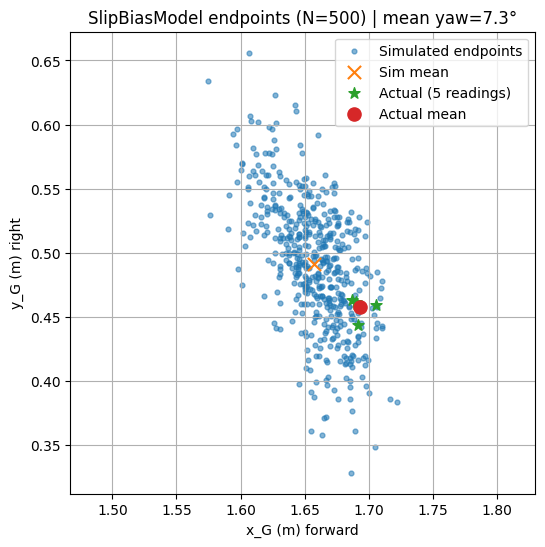

In [37]:
N_RUNS = 500
DT = 0.05

# --- Unicycle ---
xs, ys, ths, mean_xy, cov_xy, mean_yaw, yaw_std = monte_carlo_endpoints_from_sequence(
    UnicycleModel, TRAJECTORY_SEQUENCE, n_runs=N_RUNS, dt=DT, seed=10, verbose=True
)
plot_endpoints_with_actual(
    xs, ys, mean_xy, ACTUAL_POINTS,
    title=f"UnicycleModel endpoints (N={N_RUNS}) | mean yaw={math.degrees(mean_yaw):.1f}°"
)

# --- Ackermann-like ---
xs, ys, ths, mean_xy, cov_xy, mean_yaw, yaw_std = monte_carlo_endpoints_from_sequence(
    AckermannBicycleModel, TRAJECTORY_SEQUENCE, n_runs=N_RUNS, dt=DT, seed=10, verbose=True
)
plot_endpoints_with_actual(
    xs, ys, mean_xy, ACTUAL_POINTS,
    title=f"AckermannBicycleModel endpoints (N={N_RUNS}) | mean yaw={math.degrees(mean_yaw):.1f}°"
)

# --- Fancy slip+bias ---
xs, ys, ths, mean_xy, cov_xy, mean_yaw, yaw_std = monte_carlo_endpoints_from_sequence(
    FancySlipBiasModel, TRAJECTORY_SEQUENCE, n_runs=N_RUNS, dt=DT, seed=10, verbose=True
)
plot_endpoints_with_actual(
    xs, ys, mean_xy, ACTUAL_POINTS,
    title=f"SlipBiasModel endpoints (N={N_RUNS}) | mean yaw={math.degrees(mean_yaw):.1f}°"
)
